Challenger data analysis

In [119]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing_extensions import Literal
import matplotlib.pyplot as plt

Import dataset

In [2]:
orings = pd.read_csv('o-ring-erosion-only.data', sep=' ', 
                     header=None, index_col=-1,
                     names=['total', 'eroded', 'temperature', 'pressure', ''])
orings.head()

,total,eroded,temperature,pressure
,,,,
1,6,0,66,50
2,6,1,70,50
3,6,0,69,50
4,6,0,68,50
5,6,0,67,50


Code for forming design matrix.

In [3]:
# compute number of entries
n = orings.shape[0]

# compute design matrix by first getting relevant colume and stacking a column of one
X = np.hstack([np.ones((n,1)), orings[["temperature", "pressure"]].to_numpy()])

# compute output vector
y = orings["eroded"].to_numpy()

Compute loss function

In [4]:
def loss(beta: np.array, X: np.array, y: np.array) -> float:
    '''Compute value of the empirical loss.'''
    
    # compute vector of np.dot(xi, beta)
    theta = X @ beta  

    # compute vector of summands
    ell_vec = y * theta - 6 * np.log(1 + np.exp(theta))

    return np.sum(ell_vec)

Compute score vector.

In [16]:
def score(beta: np.array, X: np.array, y: np.array) -> np.array:
    '''Compute the accurate score vector.'''
    
    theta = X @ beta
    return X.T @ (y - 6 / (1 + np.exp(-theta)))

Compute a sample of score vector.

In [47]:
def score_sample(beta: np.array, X: np.array, y: np.array, 
                 rng_generator: np.random.Generator=None) -> np.array:

    if rng_generator:
        x_i = X[rng_generator.integers(n)]
        y_i = y[rng_generator.integers(n)]
    else:
        x_i = X[np.random.randint(n)]
        y_i = y[np.random.randint(n)]

    return n * (y_i - 6 / (1 + np.exp(-np.dot(x_i, beta)))) * x_i


(Stochastic) gradient descent

In [161]:
def sgd(X: np.array, y: np.array, beta_0: np.array=None, stochastic: bool=False,
        step_schedule: Literal["constant", "robbins"]="constant", alpha: float=1.,
        max_step: int=25, tol: float=1e-10, 
        rng_generator: np.random.Generator=None, 
        store_history: bool=False) -> np.array:
    
    # TODO: randomly initialise beta_0 if no initial beta_0 is given
    if beta_0 != None:
        beta = beta_0
    else:
        if rng_generator:
            beta = rng_generator.random(3)
        else:
            beta = np.zeros(3)

    if store_history:
        history = [beta]   # create list of history of beta

    # SGD
    for k in range(max_step):

        # sample score vector
        if stochastic:
            update = score_sample(beta, X, y, rng_generator)
        else:
            update = score(beta, X, y)

        # update beta
        if step_schedule == "robbins":
            new_beta = beta + alpha / (k + 1) * update
        else:
            new_beta = beta + alpha * update

        # store history
        if store_history:
            history.append(new_beta)
        
        # check if terminate
        if abs(loss(new_beta, X, y) - loss(beta, X, y)) < tol:
            break
        else:
            beta = new_beta

    # return
    if store_history:
        return history
    else:
        return new_beta

IWLS

In [109]:
def IWLS(X: np.array, y: np.array, beta_0: np.array=None, 
         step_schedule: Literal["constant", "robbins"]="constant", alpha: float=1.,
         max_step: int=25, tol: float=1e-10, 
         rng_generator: np.random.Generator=None, 
         store_history: bool=False) -> np.array:
    
    # randomly initialise beta_0 if no initial beta_0 is given
    if beta_0 != None:
        beta = beta_0
    else:
        if rng_generator:
            beta = rng_generator.random(3)
        else:
            beta = np.zeros(3)

    if store_history:
        history = [beta]   # create list of history of beta

    # IWLS
    for k in range(max_step):

        if step_schedule == "robbins":
            alpha_k = alpha / (1 + k)
        else:
            alpha_k = alpha

        # compute weights vector
        logistic = 1 / (1 + np.exp(-X @ beta))
        weights = 6 * logistic * (1 - logistic)

        # TODO: check if the alpha_k scalings are correct
        # compute target for regression
        y_tilde = y / weights
        mu_tilde = 1 / (1 - logistic)
        big_y = (alpha_k ** (1/4)) * np.sqrt(weights) * (y_tilde - mu_tilde + X @ beta / alpha_k)
        
        # compute design matrix for regression
        new_design = (alpha_k ** (1/4)) * np.sqrt(weights).reshape(-1,1) * X

        # update beta
        new_beta = np.linalg.lstsq(new_design, big_y, rcond=None)[0]

        # store history
        if store_history:
            history.append(new_beta)

        # check if terminate
        if abs(loss(new_beta, X, y) - loss(beta, X, y)) < tol:
            break
        else:
            beta = new_beta

    # return
    if store_history:
        return history
    else:
        return new_beta

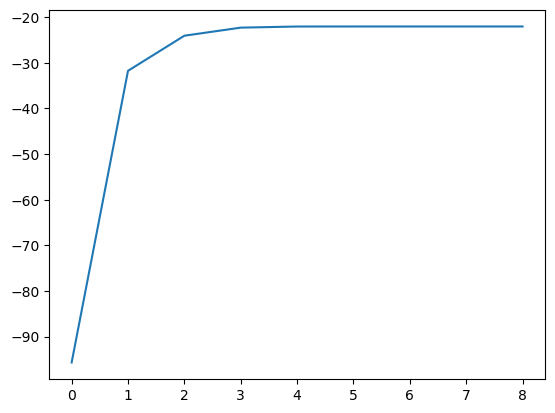

In [226]:
hist = IWLS(X, y, alpha=1, max_step=50, store_history=True)
plt.plot([loss(beta, X, y) for beta in hist])

In [227]:
hist[-1]

array([ 7.77213793e+00, -1.69735619e-01,  2.58459327e-03])

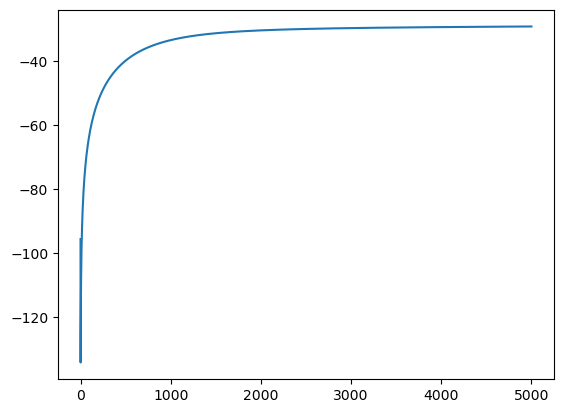

In [219]:
hist = sgd(X, y, alpha=1e-5, step_schedule="robbins", store_history=True, max_step=5000)
plt.plot([loss(beta, X, y) for beta in hist])

In [220]:
hist[-1]

array([-0.00023913, -0.02221312, -0.00815592])

In [153]:
endog = pd.DataFrame()
endog["eroded"] = orings["eroded"]
endog["normal"] = 6 - orings["eroded"]

exog = sm.add_constant(orings[["temperature", "pressure"]], prepend=False)

In [221]:
glm_binom = sm.GLM(endog, exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.params)

temperature   -0.169736
pressure       0.002585
const          7.772138
dtype: float64


In [229]:
# print(res.summary())